In [45]:
import cv2
import numpy as np
import os
import pickle
from scipy.stats import skew, kurtosis
from scipy.spatial.distance import cosine
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm
import matplotlib.pyplot as plt

# =============================================================================
# 1. FUNGSI EKSTRAKSI FITUR
# =============================================================================

In [46]:
def extract_color_features(image):
    """Mengekstrak fitur warna: HSV Histogram dan Color Moments."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # a. HSV Histogram (Bins: 16 untuk H, 8 untuk S, 8 untuk V)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, [16, 8, 8], [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    hist = hist.flatten()

    # b. Color Moments (Mean, Std, Skewness, Kurtosis) per channel
    moments = []
    for i in range(3): # H, S, V
        channel = hsv[:, :, i]
        mean = np.mean(channel)
        std = np.std(channel)
        skewness = skew(channel.flatten())
        kurt = kurtosis(channel.flatten())
        moments.extend([mean, std, skewness, kurt])

    return np.concatenate([hist, moments])

In [47]:
def extract_texture_features(image):
    """Mengekstrak fitur tekstur menggunakan GLCM."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Hitung GLCM dengan 4 arah
    distances = [1] # Jarak piksel
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4] # 0, 45, 90, 135 derajat
    glcm = graycomatrix(gray, distances=distances, angles=angles, symmetric=True, normed=True)

    # Hitung properti GLCM dan ambil rata-ratanya
    contrast = np.mean(graycoprops(glcm, 'contrast'))
    correlation = np.mean(graycoprops(glcm, 'correlation'))
    energy = np.mean(graycoprops(glcm, 'energy'))
    homogeneity = np.mean(graycoprops(glcm, 'homogeneity'))

    return np.array([contrast, correlation, energy, homogeneity])

In [48]:
def extract_shape_features(image):
    """Mengekstrak fitur bentuk."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Thresholding dengan Otsu untuk mendapatkan citra biner
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Cari kontur
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return np.zeros(6) # Return nol jika tidak ada kontur

    # Ambil kontur terbesar berdasarkan area
    main_contour = max(contours, key=cv2.contourArea)

    # Hitung fitur bentuk
    area = cv2.contourArea(main_contour)
    perimeter = cv2.arcLength(main_contour, True)

    if area == 0 or perimeter == 0:
        return np.zeros(6)

    x, y, w, h = cv2.boundingRect(main_contour)
    aspect_ratio = float(w) / h

    bounding_box_area = w * h
    extent = float(area) / bounding_box_area if bounding_box_area > 0 else 0

    hull = cv2.convexHull(main_contour)
    hull_area = cv2.contourArea(hull)
    solidity = float(area) / hull_area if hull_area > 0 else 0

    equivalent_diameter = np.sqrt(4 * area / np.pi)
    circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0

    return np.array([area, perimeter, aspect_ratio, extent, solidity, circularity])

In [49]:
def extract_features(image_path):
    """Fungsi utama untuk mengekstrak semua fitur dari sebuah gambar."""
    image = cv2.imread(image_path)
    if image is None:
        print(f"Warning: Could not read image {image_path}")
        return None, None, None, None

    # Normalisasi ukuran gambar untuk konsistensi
    image = cv2.resize(image, (256, 256))

    color_feat = extract_color_features(image)
    texture_feat = extract_texture_features(image)
    shape_feat = extract_shape_features(image)

    # Gabungkan semua fitur
    combined_feat = np.concatenate([color_feat, texture_feat, shape_feat])

    return color_feat, texture_feat, combined_feat

# =============================================================================
# 2. INDEKSASI DATABASE
# =============================================================================

In [50]:
def index_database(db_path, feature_file):
    """Mengekstrak fitur dari semua gambar di database dan menyimpannya."""
    features = {}
    image_paths = []
    for root, _, files in os.walk(db_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, file))

    for path in tqdm(image_paths, desc="Indexing Database"):
        color, texture, combined = extract_features(path)
        if combined is not None:
            features[path] = {'color': color, 'texture': texture, 'combined': combined}

    with open(feature_file, 'wb') as f:
        pickle.dump(features, f)
    print(f"Fitur dari {len(features)} gambar telah disimpan di {feature_file}")
    return features

# =============================================================================
# 3. PENCARIAN GAMBAR
# =============================================================================

In [51]:
def search(query_path, features, feature_type='combined', top_k=5):
    """Mencari gambar yang mirip berdasarkan fitur."""
    query_color, query_texture, query_combined = extract_features(query_path)

    if query_combined is None:
        print("Gagal mengekstrak fitur dari gambar query.")
        return []

    query_feat_map = {
        'color': query_color,
        'texture': query_texture,
        'combined': query_combined
    }
    query_feature = query_feat_map[feature_type]

    results = []
    for path, db_features in features.items():
        db_feature = db_features[feature_type]
        # Menggunakan Cosine Distance (1 - Cosine Similarity)
        dist = cosine(query_feature, db_feature)
        results.append((path, dist))

    results.sort(key=lambda x: x[1])
    return results[:top_k]

In [52]:
def display_results(query_path, search_results, config_name):
    """Menampilkan gambar query dan hasil pencarian."""
    query_img = cv2.imread(query_path)
    query_img = cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)

    # 1. Set the figure background to actual white
    plt.figure(figsize=(15, 5), facecolor='white')
    plt.suptitle(f'Hasil Pencarian - Konfigurasi: {config_name}', fontsize=16)

    # Tampilkan gambar query
    plt.subplot(1, 6, 1)
    plt.imshow(query_img)
    plt.title("Query Image")
    plt.axis('off')

    # Tampilkan hasil Top-5
    for i, (path, dist) in enumerate(search_results):
        result_img = cv2.imread(path)
        result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, 6, i + 2)
        plt.imshow(result_img)
        plt.title(f"Rank {i+1}\nDist: {dist:.4f}")
        plt.axis('off')

    # 2. Use tight_layout() to optimize spacing (from your working example)
    # We use rect to prevent the suptitle from being cut off by tight_layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # 3. Save the figure *before* showing it
    # We can also add facecolor='white' here to be 100% sure
    # the saved file's background is white.
    plt.savefig(
        f"results/result_{os.path.basename(query_path)}_{config_name}.png",
        bbox_inches='tight',
        facecolor='white' # Ensures saved file bg is white
    )

    # 4. Show the plot
    plt.show()

# =============================================================================
# 4. EVALUASI
# =============================================================================

In [53]:
def get_class_from_path(path):
    """Mendapatkan nama kelas dari path (berdasarkan nama folder)."""
    return os.path.basename(os.path.dirname(path))

In [54]:
def evaluate_precision(query_folder, features, feature_type, top_k=5):
    """Menghitung rata-rata Precision@5."""
    total_precision = 0
    query_count = 0

    for query_file in os.listdir(query_folder):
        query_path = os.path.join(query_folder, query_file)
        if not query_path.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        # Asumsi nama query file mengandung nama kelasnya untuk evaluasi
        # Contoh: `classA_query.jpg`
        # Atau bisa juga dengan membuat subfolder di dalam folder query
        query_class = get_class_from_path(query_path) # Jika query disimpan dalam subfolder kelas
        # query_class = query_file.split('_')[0] # Jika nama file mengandung kelas

        search_results = search(query_path, features, feature_type, top_k)

        relevant_count = 0
        for path, _ in search_results:
            result_class = get_class_from_path(path)
            if result_class == query_class:
                relevant_count += 1

        precision = relevant_count / top_k
        total_precision += precision
        query_count += 1

    return total_precision / query_count if query_count > 0 else 0

# =============================================================================
# MAIN SCRIPT
# =============================================================================

Memuat fitur dari file...


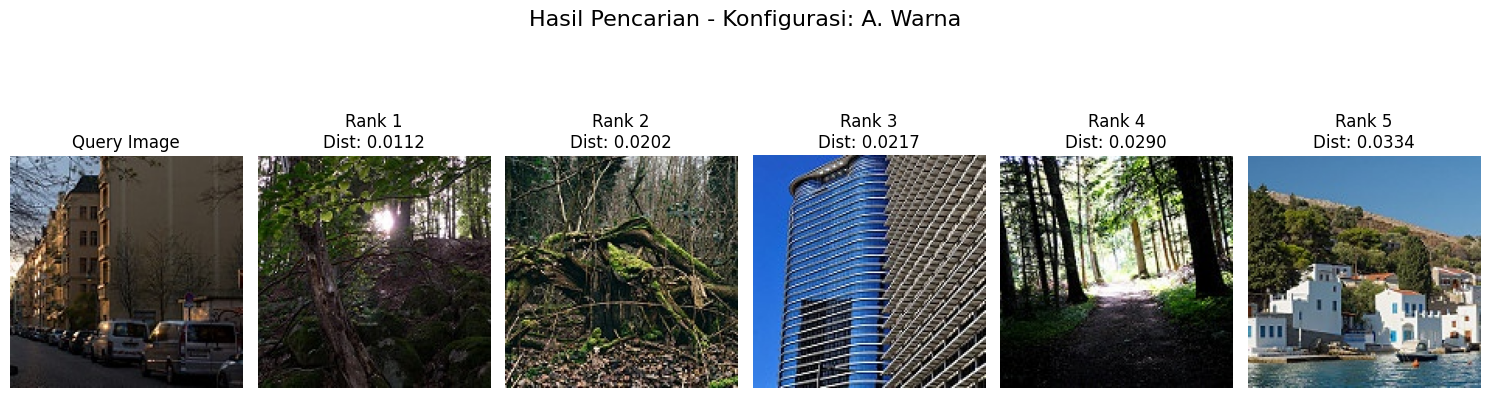

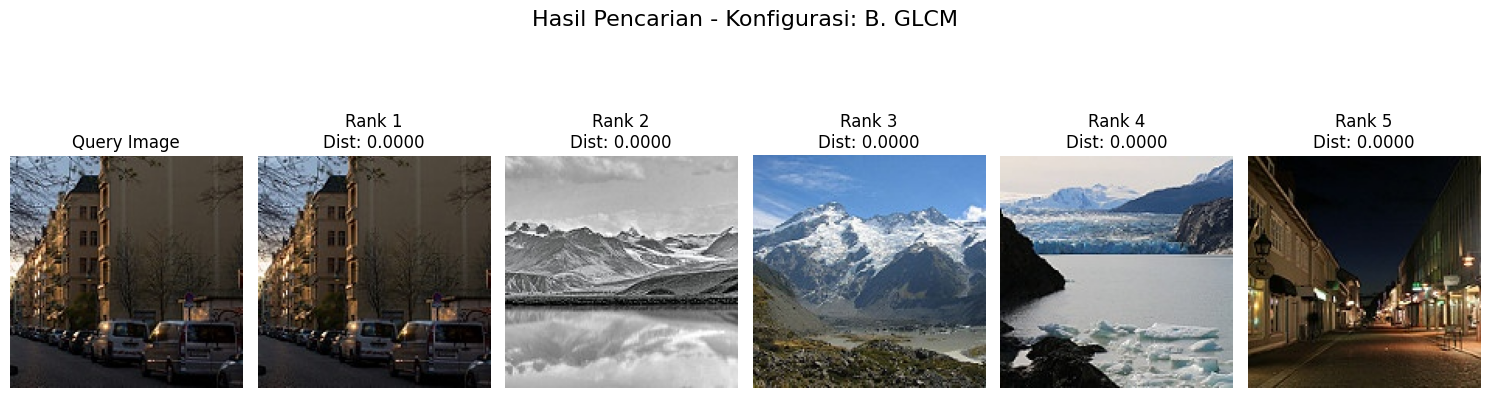

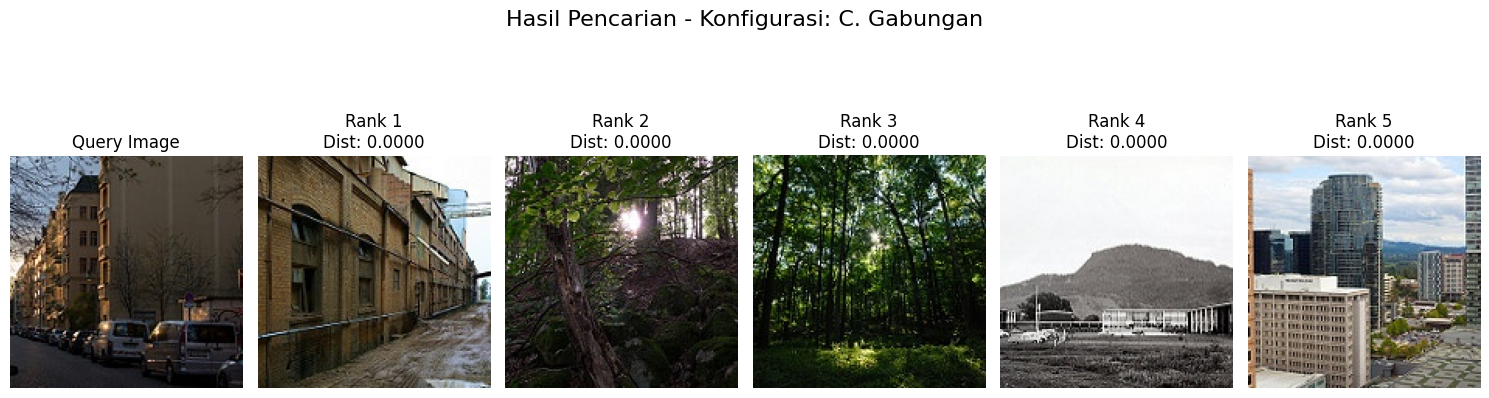


Memulai evaluasi Precision@5...
Struktur folder query untuk evaluasi tidak ditemukan. Harap siapkan folder query dengan subfolder kelas.


In [55]:
DB_PATH = 'db_80/'
QUERY_PATH = 'query/'
FEATURE_FILE = 'features.pkl'

# --- Langkah 1: Indexing Database (hanya perlu dijalankan sekali) ---
# Cek jika file fitur sudah ada, jika tidak, buat baru.
if not os.path.exists(FEATURE_FILE):
    print("File fitur tidak ditemukan. Memulai proses indeksasi...")
    db_features = index_database(DB_PATH, FEATURE_FILE)
else:
    print("Memuat fitur dari file...")
    with open(FEATURE_FILE, 'rb') as f:
        db_features = pickle.load(f)

# --- Langkah 2: Lakukan Pencarian untuk Contoh Query ---
# Pilih satu gambar dari folder query Anda
example_query = os.path.join(QUERY_PATH, 'street/2.jpg') # Ganti sesuai nama file query Anda

# Cari dengan konfigurasi A (Warna)
results_color = search(example_query, db_features, feature_type='color', top_k=5)
display_results(example_query, results_color, "A. Warna")

# Cari dengan konfigurasi B (Tekstur GLCM)
results_texture = search(example_query, db_features, feature_type='texture', top_k=5)
display_results(example_query, results_texture, "B. GLCM")

# Cari dengan konfigurasi C (Gabungan)
results_combined = search(example_query, db_features, feature_type='combined', top_k=5)
display_results(example_query, results_combined, "C. Gabungan")

# --- Langkah 3: Evaluasi Sistem ---
print("\nMemulai evaluasi Precision@5...")

# Untuk evaluasi, pastikan folder query Anda punya subfolder per kelas, contoh:
# query/
# |-- class_A/
# |   |-- query_A_01.jpg
# |   |-- query_A_02.jpg
# |-- class_B/
# |   |-- query_B_01.jpg

# Buat folder dummy untuk evaluasi jika belum ada
if not os.path.exists(os.path.join(QUERY_PATH, 'class_A')):
    print("Struktur folder query untuk evaluasi tidak ditemukan. Harap siapkan folder query dengan subfolder kelas.")
else:
    # A. Warna
    p_color = evaluate_precision(QUERY_PATH, db_features, 'color', top_k=5)

    # B. GLCM
    p_texture = evaluate_precision(QUERY_PATH, db_features, 'texture', top_k=5)

    # C. Gabungan
    p_combined = evaluate_precision(QUERY_PATH, db_features, 'combined', top_k=5)

    print("\n--- Hasil Evaluasi Precision@5 ---")
    print(f"Konfigurasi A (Warna):     {p_color:.4f}")
    print(f"Konfigurasi B (GLCM):      {p_texture:.4f}")
    print(f"Konfigurasi C (Gabungan):  {p_combined:.4f}")